In [ ]:
# for cleaning up after tests
import os
dir = "../calibrate/stacks/"
for f in os.listdir(dir):
    if ".bin" in f:
        os.remove(os.path.join(dir, f))

In [1]:
from banners import *
# import csv_relations
import os
root = "../calibrate"
# get all dirs with data and order by date
'''
data_dirs = []
for dd in os.listdir(root):
    d = os.path.join(root, dd)
    print(d)
    if os.path.isdir(d):
        dir_files = Dir(d, dd)
        for f in os.listdir(d):
            if ".bag" in f:
                dir_files.bag = os.path.join(d, f)
            if ".csv" in f:
                dir_files.clicks = os.path.join(d, f)
        data_dirs.append(dir_files)
'''
data_dirs = []
dir_files = Dir(root, "test")
dir_files.bag = os.path.join(root, "rtk-co-locate.bag")
dir_files.clicks = os.path.join(root, "rtk-clicks.csv")
data_dirs.append(dir_files)

print(data_dirs)

TOPICS = ['/current_pose', '/cam0/nv12_decode_result', '/cam1/nv12_decode_result', '/therm/image_raw_throttle']

processed_data = []

# process each bag
for a in data_dirs:
    cc = CameraCombo(a)
    bag = rosbag.Bag(a.bag)
    for topic, msg, t in bag.read_messages(TOPICS):
        # print(topic)
        # stack 3 images together
        if topic == '/therm/image_raw_throttle':
            # print("thermal")
            cc.flir = msg
        if topic == '/cam1/nv12_decode_result':
            # print("rgb")
            cc.rgb = msg

        if topic == '/cam0/nv12_decode_result':
            # print("noir")
            cc.noir = msg
        if topic == "/current_pose":
            # print("stacking")
            cc.pose = msg.pose.pose
            cc.stack(t)
    processed_data.append(cc)
    cc.done()


    # get pose of stack
    # compute coords(xmin, ymin & xmax, ymax) of each stack
processed_data[0].parsed["xmax"]

[Dir(path='../calibrate', date='test', bag='../calibrate/rtk-co-locate.bag', clicks='../calibrate/rtk-clicks.csv')]
[-1.27600274 -0.87306525  1.        ] [0.31295456 1.9499852  1.        ]
[  550422.29216243 -4005965.66690009   850252.62474308] [  550422.78256748 -4005962.77881518   850251.24167851]
[-1.27600274 -0.87306525  1.        ] [0.31295456 1.9499852  1.        ]
[ 1035139.23708034 -3854821.59754482  1068874.31077139] [ 1035139.41556485 -3854818.72620748  1068872.82148823]
[-1.27600274 -0.87306525  1.        ] [0.31295456 1.9499852  1.        ]
[ 1036999.58158483 -3854066.48504751  1069793.64880695] [ 1036999.75884597 -3854063.61387417  1069792.15906156]
[-1.27600274 -0.87306525  1.        ] [0.31295456 1.9499852  1.        ]
[ 1441985.00632155 -3652546.63652825  1285782.76553218] [ 1441984.91160612 -3652543.82198774  1285781.16434828]
[-1.27600274 -0.87306525  1.        ] [0.31295456 1.9499852  1.        ]
[ 1443829.92418054 -3651441.50689084  1286850.8424068 ] [ 1443829.82819

0      5.504223e+05
1      1.035139e+06
2      1.037000e+06
3      1.441985e+06
4      1.443830e+06
           ...     
855    6.945873e+05
856    6.971637e+05
857    6.971918e+05
858    7.036231e+05
859    7.036231e+05
Name: xmax, Length: 860, dtype: float64

In [2]:
import csv
import csv_relations
# import pymap3d as pm
import utm
proc_click = []

origin = None

data_dirs[0].clicks = '../calibrate/rtk-click.csv'

# go over the CSVs
for a in data_dirs:
    C = csv_relations.CSVAugmented(a.path)
    with open(a.clicks) as clicks:
        reader = csv.reader(clicks)
        for line in reader:
            if origin == None:
                origin = [float(line[0]), float(line[1]), float(line[2])]
            # breakdown line
            u = utm.from_latlon(float(line[0]), float(line[1]))
            # u = pm.geodetic2ned(float(line[0]), float(line[1]), float(line[2]), origin[0], origin[1], origin[2])
            pt = [u[0], u[1]]
            # print(u)
            health = int(line[-1])
            
            C.jungler(pt, health, processed_data)

    C.done()
    proc_click.append(C)

Series([], Name: save_loc, dtype: object)


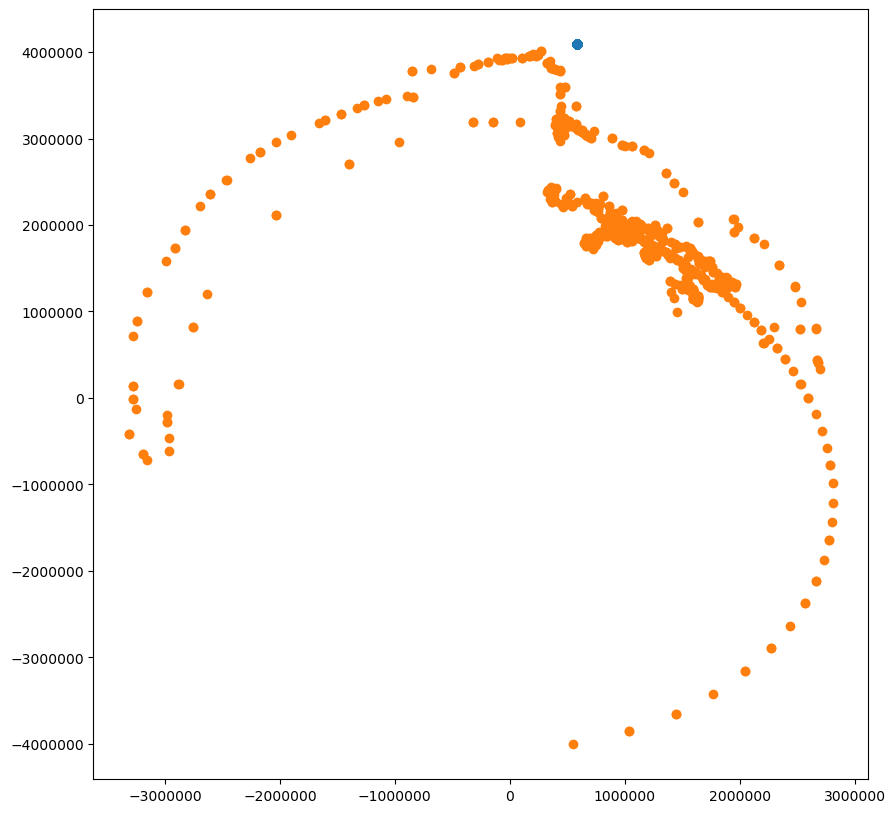

In [3]:
# plot things
import matplotlib.pyplot as plt
from matplotlib import patches

fig, ax = plt.subplots(figsize=(10, 10))

# ===============plot trajectory===============
# get x and y of trajectory
p_x = processed_data[0].parsed.pose.map(lambda x: x[0, 3])
p_y = processed_data[0].parsed.pose.map(lambda x: x[1, 3])
ax.scatter(p_x, p_y)

# plot vision cones
xmaxs = processed_data[0].parsed.xmax.tolist()
ymaxs = processed_data[0].parsed.ymax.tolist()
widths = np.asarray(xmaxs) - np.asarray(processed_data[0].parsed.xmin.tolist())
heights = np.asarray(ymaxs) - np.asarray(processed_data[0].parsed.ymin.tolist())
ax.scatter(xmaxs, ymaxs)


In [ ]:
import matplotlib.patches as patches
from cv_bridge import CvBridge
from sensor_msgs.msg import Image

bridge = CvBridge()

# back projection time
def pretty_image(point, image, dataframe, img_type):
    file = open(image, 'rb')
    imgs = pickle.load(file)
    row = dataframe.loc[dataframe['save_loc'] == image]
    pose = row.pose.item()
    # subtract xmax and ymax from pt then use K to project back
    x = pt[0] - pose[0, 3]
    y = pt[1] - pose[1, 3]
    print(x, y)
    # print(type(list(imgs['rgb'].data)))
    fig, ax = plt.subplots()
    if img_type == 'flir':
        img = bridge.imgmsg_to_cv2(imgs[img_type])
        K = flir_K
    else:
        img = np.asarray(list(imgs[img_type].data)[:1080*1920]).reshape((1080, 1920))
        if img_type == 'noir':
            K = noir_K
        else:
            K = rbg_K

    l = np.array([x, y, 10]).T
    # print(l)
    xy = K@l
    print(xy)
    xy = xy / xy[2]
    x = xy[0]
    y = xy[1]
    # print(img.shape)
    ax.imshow(img)
    rect = patches.Rectangle((x, y), 40, 30, linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect)

    plt.show()

def demo_wrapper(c, r, img_type):
    click_to_use = c
    relation_to_use = r
    pt = [proc_click[0].related.x[click_to_use], proc_click[0].related.y[click_to_use]]
    imgs = proc_click[0].related.relevant[0][relation_to_use]
    pretty_image(pt, imgs, processed_data[0].parsed, img_type)

demo_wrapper(0, 10, 'rgb')
# demo_wrapper(1, 10)

In [ ]:
for i in range(5):
    demo_wrapper(45, i, 'flir')